# 1. 인트로

## 1-1. 세미프로젝트 설명

주제 : 업무 페이스 메이커\
목적 : 카메라를 통해 PC사용자의 안면을 인식한 후, 표정을 검출하여 유저 상황에 따른 대처를 자동으로 해주는 프로그램 생성\
사용할 모델 : 

## 1-2. 패키지 로드

In [ ]:
!pip install torchsummary

In [14]:
import numpy as np
import cv2, sys
import datetime
import dlib
import matplotlib.pyplot as plt
from imutils import face_utils
import seaborn as sns
import pandas as pd


from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix


## 1-3. 데이터 로드

https://github.com/kairess/eye_blink_detector 에서 학습 데이터 다운로드\
학습 데이터 2586개\
검증 데이터  288개

In [2]:
x_train = np.load("./dataset/x_train.npy").astype(np.float32)
y_train = np.load("./dataset/y_train.npy").astype(np.float32)
x_val = np.load("./dataset/x_val.npy").astype(np.float32)
y_val = np.load("./dataset/y_val.npy").astype(np.float32)

In [3]:
print(x_train.shape, y_train.shape)

(2586, 26, 34, 1) (2586, 1)


In [4]:
print(x_val.shape, y_val.shape)

(288, 26, 34, 1) (288, 1)


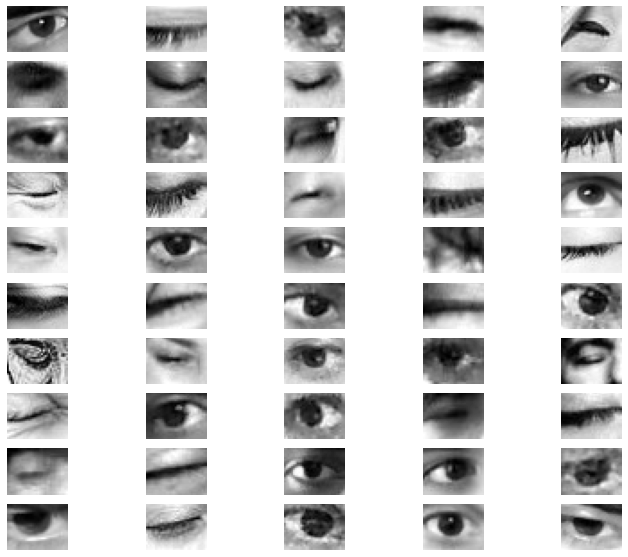

In [6]:
plt.figure(figsize=(12, 10))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(x_train[i].reshape((26, 34)), cmap='gray')

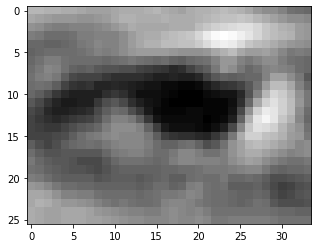

In [5]:
# train 데이터의 11번째 눈사진 데이터
plt.imshow(x_train[10], cmap="gray")
plt.show()

### 학습데이터의 증강 ImageDataGenerator

이미지 크기 설정 : rescale=None\
회전 각도 범위 설정 : rotation_range=0\
좌우 이동 범위 설정 : width_shift_range=0.0\
상하 이동 범위 설정 : height_shift_range=0.0\
밀림 강도 범위 설정 : shear_range=0.0


In [8]:
train_datagen = ImageDataGenerator(
    
    rescale=1./255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2

)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
train_generator = train_datagen.flow(

    x = x_train, y = y_train,
    batch_size = 32,
    shuffle = True

)

val_generator = val_datagen.flow(
    
    x=x_val, y=y_val,
    batch_size=32,
    shuffle = False #검증 데이터는 데이터를 섞을 필요가 없음

)

커널의 수를 32, 64, 128로 변경해 주면서\
컨벌루션 레이어를 1차원으로 펴줌

In [10]:
inputs = Input(shape = (26,34,1)) #(세로,가로,흑백)

net = Conv2D(32, kernel_size=3, strides =1, padding="same",activation="relu")(inputs)
net = MaxPooling2D(pool_size=2)(net) #차원축소

net = Conv2D(64, kernel_size=3, strides =1, padding="same",activation="relu")(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides =1, padding="same",activation="relu")(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation("relu")(net)
net = Dense(1)(net)
outputs = Activation("sigmoid")(net)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["acc"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

제너레이터로 데이터를 불러왔을때 .fit_generator()로 학습시키는게 좋음\
모델이 좋으면 저장 : ModelCheckpoint()\
학습이 잘 안되면 러닝레이트를 줄여라 : ReduceLROnPlateau()

In [11]:
start_time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

model.fit_generator(
train_generator, epochs=50, validation_data=val_generator,
callbacks=[
    ModelCheckpoint("models/%s.h5"%(start_time),monitor="val_acc",save_best_only=True, mode="max",verbose=1),
    ReduceLROnPlateau(monitor="val_acc", factor=0.2, patience=10, verbose=1,mode="auto",min_lr=1e-05)
])

C:\Users\wpgud\AppData\Local\Temp\ipykernel_2088\3963820486.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 0.4526 - acc: 0.7846
Epoch 1: val_acc improved from -inf to 0.92014, saving model to models\2022_08_03_03_49_07.h5
81/81 [==============================] - 7s 64ms/step - loss: 0.4526 - acc: 0.7846 - val_loss: 0.2291 - val_acc: 0.9201 - lr: 0.0010
Epoch 2/50
80/81 [============================>.] - ETA: 0s - loss: 0.2502 - acc: 0.9009
Epoch 2: val_acc improved from 0.92014 to 0.95139, saving model to models\2022_08_03_03_49_07.h5
81/81 [==============================] - 5s 59ms/step - loss: 0.2510 - acc: 0.9010 - val_loss: 0.1369 - val_acc: 0.9514 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.1863 - acc: 0.9285
Epoch 3: val_acc improved from 0.95139 to 0.96528, saving model to models\2022_08_03_03_49_07.h5
81/81 [==============================] - 5s 64ms/step - loss: 0.1863 - acc: 0.9285 - val_loss: 0.0800 - val_acc: 0.9653 - lr: 0.0010
Epoch 4/50
81/81 [============================


Epoch 29: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
81/81 [==============================] - 5s 58ms/step - loss: 0.0121 - acc: 0.9954 - val_loss: 0.0100 - val_acc: 0.9965 - lr: 2.0000e-04
Epoch 30/50
81/81 [==============================] - ETA: 0s - loss: 0.0138 - acc: 0.9954
Epoch 30: val_acc improved from 0.99653 to 1.00000, saving model to models\2022_08_03_03_49_07.h5
81/81 [==============================] - 5s 61ms/step - loss: 0.0138 - acc: 0.9954 - val_loss: 0.0068 - val_acc: 1.0000 - lr: 4.0000e-05
Epoch 31/50
81/81 [==============================] - ETA: 0s - loss: 0.0125 - acc: 0.9957
Epoch 31: val_acc did not improve from 1.00000
81/81 [==============================] - 5s 60ms/step - loss: 0.0125 - acc: 0.9957 - val_loss: 0.0058 - val_acc: 1.0000 - lr: 4.0000e-05
Epoch 32/50
81/81 [==============================] - ETA: 0s - loss: 0.0160 - acc: 0.9946
Epoch 32: val_acc did not improve from 1.00000
81/81 [==============================] - 5s 58ms

모델 학습률 확인

9/9 [==============================] - 0s 23ms/step
test acc: 1.0


C:\Users\wpgud\AppData\Local\Temp\ipykernel_2088\4113972454.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_logical = (y_pred > 0.5).astype(np.int)


<AxesSubplot:>

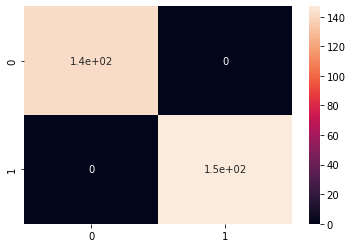

In [15]:
model = load_model("models/%s.h5"%(start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print("test acc: %s" % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot = True)

In [16]:
IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

model = load_model('./models/2022_08_03_03_49_07.h5')
model.summary()

def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

# main
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("video open failed")
    sys.exit()

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2.imshow('l', eye_img_l)
    cv2.imshow('r', eye_img_r)

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2.imshow('result', img)
  if cv2.waitKey(1) == ord('q'):
    break

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

C:\Users\wpgud\AppData\Local\Temp\ipykernel_2088\4144521951.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


# 2. 데이터 전처리

# 3. 학습 & 예측

# 4. 성능지표